In [78]:
maxfit_l1_path = '../output/subtractive-ablation-mnist-models/relu-max_fit_l1.pkl'
all_modifications_path = '../output/ablation-mnist-models/relog-elliptical-maxout_4-bce-max_fit_l1-overlay.pkl'
minus_bce_path = '../output/ablation-mnist-models/relog-elliptical-maxout_4-max_fit_l1.pkl'
minus_l1_path = '../output/subtractive-ablation-mnist-models/relog-elliptical-maxout_4-bce-overlay.pkl'
minus_maxout_path = '../output/subtractive-ablation-mnist-models/relog-elliptical-bce-max_fit_l1-overlay.pkl'
minus_elliptical_path = '../output/subtractive-ablation-mnist-models/relog-maxout_4-bce-max_fit_l1-overlay.pkl'
minus_relog_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-maxout_4-bce-max_fit_l1-overlay.pkl'

relu_path = '../output/ablation-mnist-models/relu.pkl'
relog_path = '../output/ablation-mnist-models/relog.pkl'
elliptical_path = '../output/subtractive-ablation-mnist-models/relu-elliptical.pkl'
elliptical_maxfit_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-max_fit_l1.pkl'
relog_elliptical_maxfit_path = '../output/subtractive-ablation-mnist-models/relog-elliptical-max_fit_l1.pkl'
relu_elliptical_maxout_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-maxout.pkl'
relu_elliptical_maxfit_maxout_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-max_fit-maxout.pkl'
maxout_path = '../output/subtractive-ablation-mnist-models/relu-maxout.pkl'
minmaxout_path = '../output/subtractive-ablation-mnist-models/relu-minmaxout.pkl'
bce_path = '../output/subtractive-ablation-mnist-models/relu-bce.pkl'
overlay_path = '../output/subtractive-ablation-mnist-models/relu-bce-overlay.pkl'
maxfit_path = '../output/subtractive-ablation-mnist-models/relu-max_fit_l1.pkl'

relu_more_noise_path = '../output/mnist-models-more-noise/relu.pkl'
innate_more_noise_path = '../output/mnist-models-more-noise/relog-elliptical-maxout_4-max_fit_l1.pkl'

# Preparation

In [79]:
import sys
sys.path.append('..')

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision
import numpy as np
from torch.nn.functional import softmax
import os

In [81]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

In [82]:
dataset = torchvision.datasets.MNIST(
            root='../mnist',
            train=True,
            transform=torchvision.transforms.ToTensor(), 
            download=False,
        )
loader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False)

In [83]:
x, y = next(iter(loader))

In [105]:
from train import cifar_stats

# levels of noise
k = torch.linspace(0, 1, 101).reshape(-1, 1, 1, 1)

softmax_dim1 = lambda x: softmax(x, dim=1)

def denormalize_cifar_images(batch):
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return batch * stds + means

cifar_classes = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck',
}

class Plotter(object):

    def __init__(self, idx=None, is_cifar=False):
        self.is_cifar = is_cifar
        idx = idx or np.random.randint(x.shape[0])
        print("Plotting image at index %d" % idx)
        sample1 = x[[idx]]
        if is_cifar:
            sample2 = torch.randn(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k
        else:
            sample2 = torch.rand(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k

    def plot_transition(self):
        if self.xs.shape[1] == 1: # black-and-white
            xs_vals = self.xs[:,0,:,:].numpy()
        elif self.xs.shape[1] == 3: # R-G-B
            if self.is_cifar:
                images = denormalize_cifar_images(self.xs)
            else:
                images = self.xs
            xs_vals = images.permute(0,2,3,1).numpy()
        else:
            raise ValueError('Unsupported image format')
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        ax[0].imshow(xs_vals[0])
        ax[0].set_title('Noise level: 0%')
        ax[1].imshow(xs_vals[25])
        ax[1].set_title('Noise level: 25%')
        ax[2].imshow(xs_vals[50])
        ax[2].set_title('Noise level: 50%')
        ax[3].imshow(xs_vals[70])
        ax[3].set_title('Noise level: 75%')
        ax[4].imshow(xs_vals[100])
        ax[4].set_title('Noise level: 100%')

    def plot_predictions(self, model, name=None, normalize_func=softmax_dim1, ax=None):
        name = name or model.name
        ax = ax or plt
        model.eval()
        preds, _ = model(self.xs)
        if normalize_func is not None:
            preds = normalize_func(preds)
        c0, c1 = preds[0].argsort(descending=True)[:2]
        pred_on_noise = preds[-1].clone()
        pred_on_noise[c0] = pred_on_noise[c1] = -np.inf # ignore the classes we have chosen already
        c2, c3 = pred_on_noise.argsort(descending=True)[:2]
        k_vals = k.flatten().numpy()
        for c in [c0, c1, c2, c3]:
            c = c.item()
            if self.is_cifar:
                class_name = cifar_classes[c]
            else:
                class_name = str(c)
            ax.plot(k_vals, preds[:,c].detach().numpy(), label='prediction: %s' %class_name)
        if hasattr(ax, 'set_ylim'): 
            ax.set_ylim(0, 1)
            ax.set_title('Model: ' + name)
        else:
            ax.ylim(0, 1)
            ax.title('Model: ' + name)
        ax.legend()

In [85]:
def compare_visually(model_a, model_b, idx, is_cifar=False):
    p = Plotter(idx, is_cifar=is_cifar)
    plt.ion()
    p.plot_transition()
    _, axes = plt.subplots(1, 2, figsize=(20,8))
    p.plot_predictions(model_a, ax=axes[0])
    p.plot_predictions(model_b, ax=axes[1])
    plt.ioff()

# Compare two models visually

In [86]:
model_a = load_model(relu_path)
model_b = load_model(all_modifications_path)
model_a.name = 'Baseline'
model_b.name = 'Proposed'

Plotting image at index 84


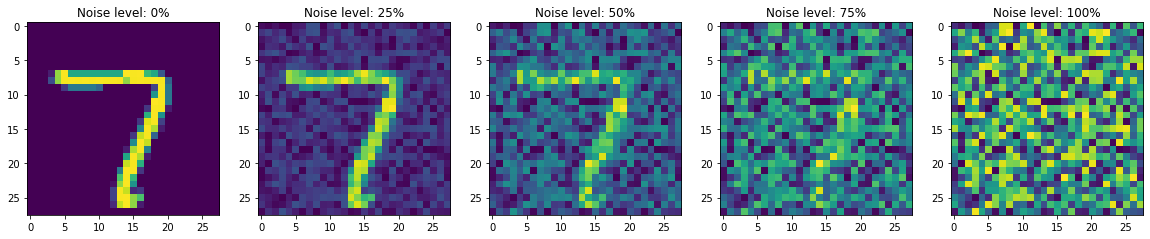

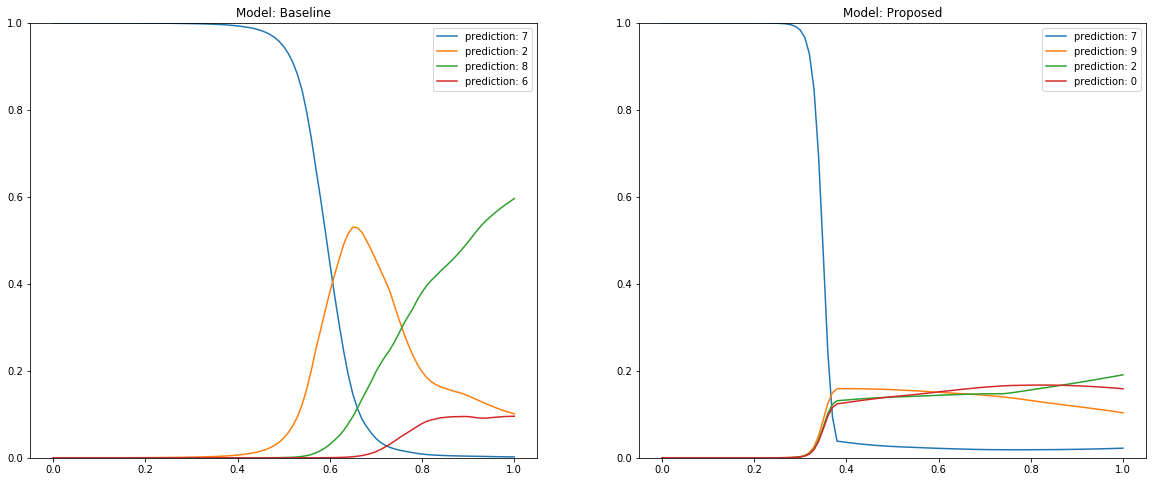

In [87]:
compare_visually(model_a, model_b, 84)

Plotting image at index 41


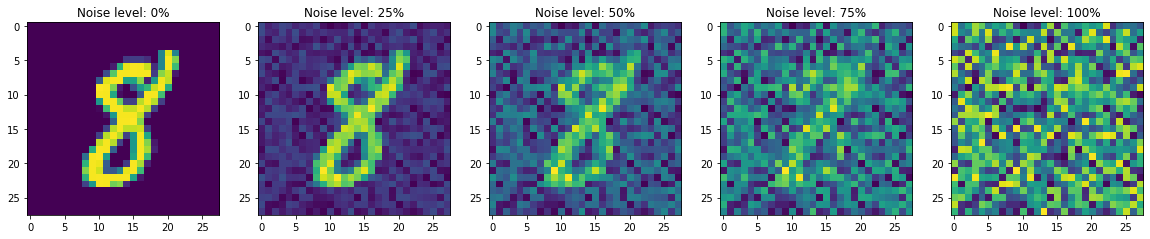

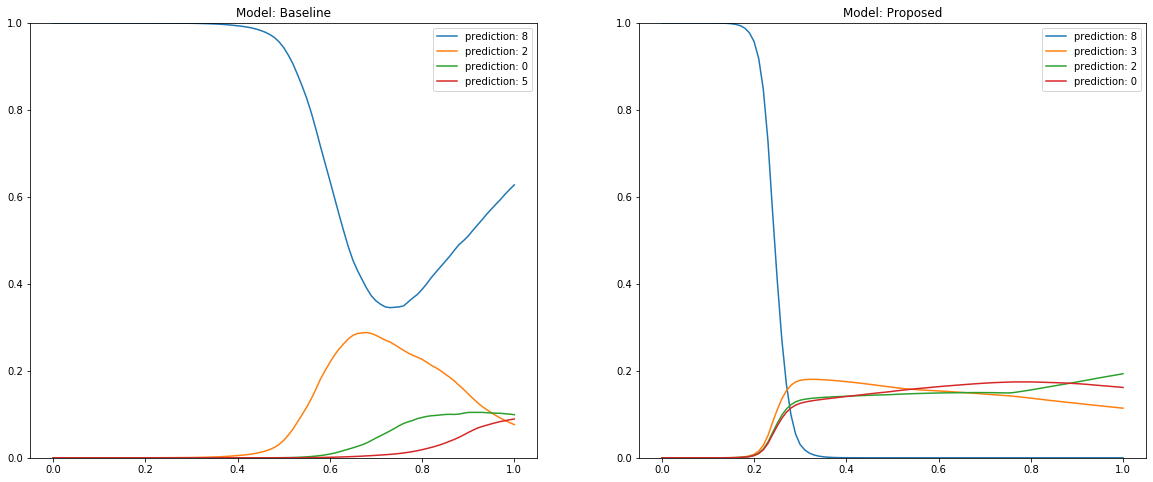

In [88]:
compare_visually(model_a, model_b, 41)

Plotting image at index 8


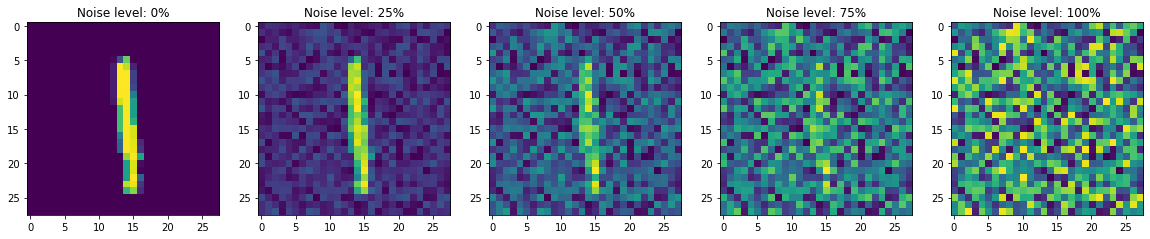

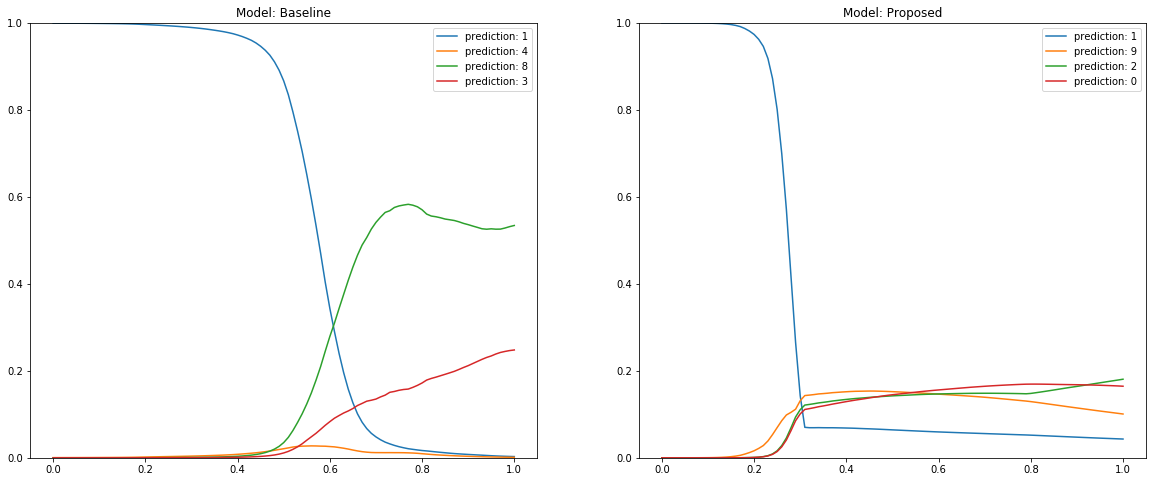

In [89]:
compare_visually(model_a, model_b, 8)

Plotting image at index 2978


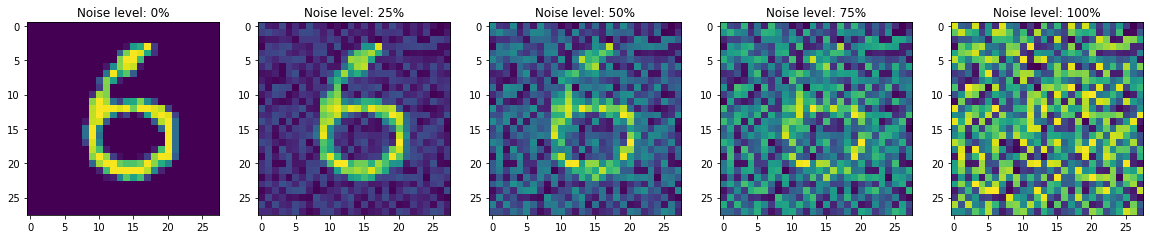

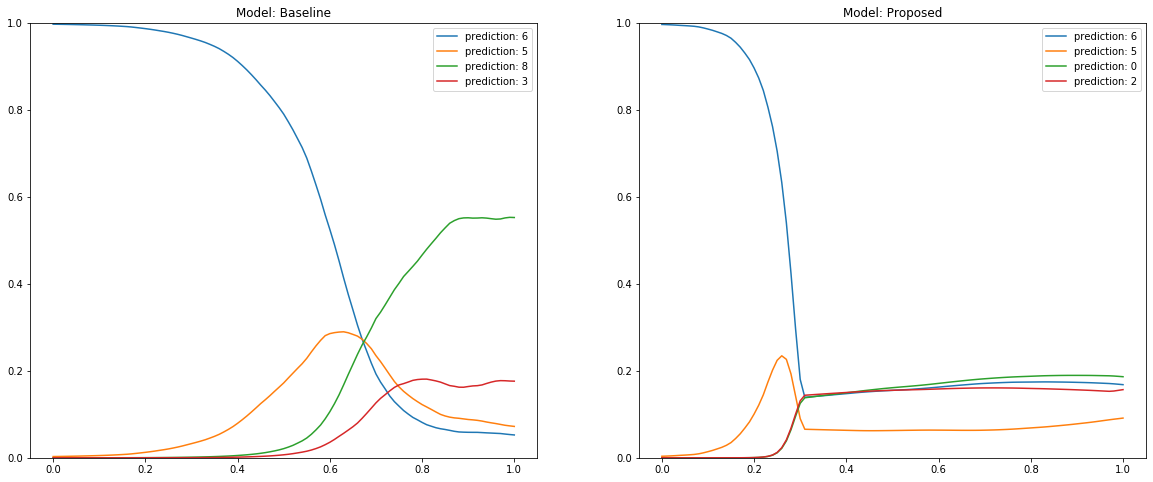

In [90]:
compare_visually(model_a, model_b, 2978)

# Classifying rubbish class examples

In [91]:
noise_images = torch.rand(*x.shape)
# noise_images = torch.randn(*x.shape)

def measure_accuracy_on_noise(model):
    preds, _ = model(noise_images)
    max_probs, _ = softmax(preds, dim=1).max(dim=1)
    accuracies = (max_probs < 0.5).float().reshape(-1, 100).mean(dim=1)
    return accuracies.mean().item(), accuracies.std().item()

In [92]:
measure_accuracy_on_noise(model_a)

(0.37209999561309814, 0.044342443346977234)

In [93]:
measure_accuracy_on_noise(model_b)

(1.0, 0.0)

In [94]:
paths = [relu_path, relog_path, maxout_path,
         minmaxout_path, elliptical_path, maxfit_path, 
         bce_path, overlay_path, elliptical_maxfit_path, 
         relog_elliptical_maxfit_path, minus_bce_path,
         relu_elliptical_maxout_path, relu_elliptical_maxfit_maxout_path]

In [133]:
assert all(os.path.exists(path) for path in paths)

In [ ]:
for path in paths:
    print('%s: %.2f (std=%.2f)' %(os.path.basename(path), *measure_accuracy_on_noise(load_model(path))))

relu.pkl: 0.37 (std=0.04)


Previous result (2019):

```
for path in paths:
    print('%s: %.2f (std=%.2f)' %(os.path.basename(path), *measure_accuracy_on_noise(load_model(path))))
    
relu.pkl: 0.28 (std=0.05)
relog.pkl: 0.06 (std=0.03)
relu-maxout.pkl: 0.05 (std=0.02)
relu-minmaxout.pkl: 0.02 (std=0.01)
relu-elliptical.pkl: 0.01 (std=0.01)
relu-max_fit_l1.pkl: 0.48 (std=0.05)
relu-mse.pkl: 0.08 (std=0.03)
relu-mse-overlay.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-maxout_4-max_fit_l1.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit-maxout.pkl: 0.79 (std=0.04)
relu-elliptical-maxout.pkl: 0.03 (std=0.02)
```

In [96]:
# check if the architecture is correct
load_model(relu_elliptical_maxout_path)

CNN(
  (features): Sequential(
    (0): EllipticalCNN(
      1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (_quadratic): AbsConv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    )
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): EllipticalCNN(
      16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (_quadratic): AbsConv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    )
    (5): FoldingMaxout(use_min=False, k=4)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Elliptical(
      in_features=1568, out_features=40, bias=True
      (_quadratic): AbsLinear(in_features=1568, out_features=40, bias=False)
    )
    (1): FoldingMaxout(use_min=False, k=4)
  )
)

## Examining some models

In [99]:
relu_elliptical_maxfit_maxout = load_model(relu_elliptical_maxfit_maxout_path)
relu_elliptical_maxfit_maxout.name = 'MaxFit + Elliptical + MaxOut'

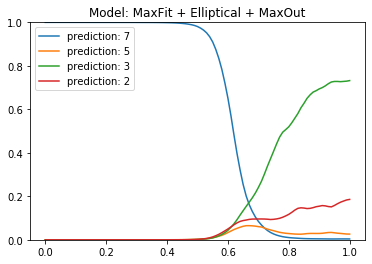

In [107]:
p = Plotter(223)
p.plot_predictions(relu_elliptical_maxfit_maxout)

Plotting image at index 5898


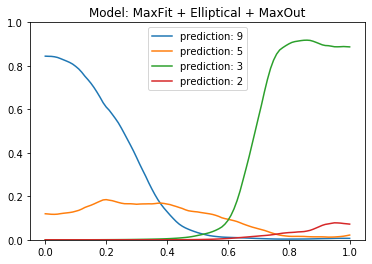

In [111]:
p = Plotter(5898)
p.plot_predictions(relu_elliptical_maxfit_maxout)

Plotting image at index 6753


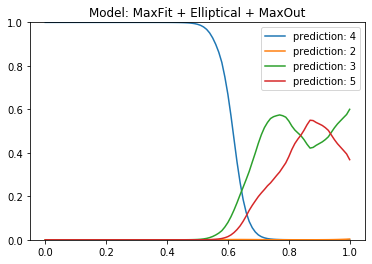

In [112]:
p = Plotter(6753)
p.plot_predictions(relu_elliptical_maxfit_maxout)

Plotting image at index 4148


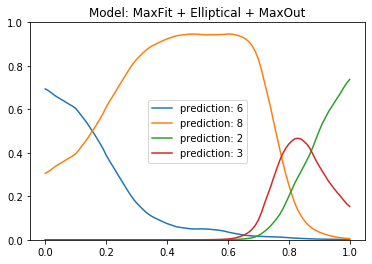

In [113]:
p = Plotter(4148)
p.plot_predictions(relu_elliptical_maxfit_maxout)

# CIFAR-10 models

In [39]:
cifar10_baseline_path = '../output/ablation-cifar10-models/relu.pkl'
cifar10_modified_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit.pkl'
cifar10_modified_with_bce_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit-bce.pkl'
cifar10_modified_with_overlay_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit-bce-overlay.pkl'

In [41]:
cifar10_model_a = load_model(cifar10_baseline_path)
cifar10_model_b = load_model(cifar10_modified_path)
cifar10_model_c = load_model(cifar10_modified_with_bce_path)
cifar10_model_d = load_model(cifar10_modified_with_overlay_path)

In [64]:
cifar10_model_a.name = 'Baseline'
cifar10_model_b.name = 'Proposed (no BCE)'
cifar10_model_d.name = 'Proposed (BCE+Overlay)'

In [13]:
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*cifar_stats)
])
cifar10_testset = torchvision.datasets.CIFAR10(root='../cifar10', train=False, download=False, transform=transform_test)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=256, shuffle=False, num_workers=2)

In [14]:
x, y = next(iter(cifar10_testloader))

In [71]:
p = Plotter(3, is_cifar=True)

Plotting image at index 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


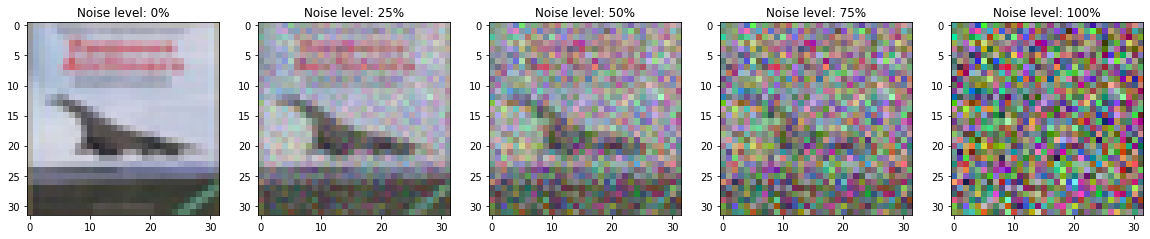

In [72]:
p.plot_transition()

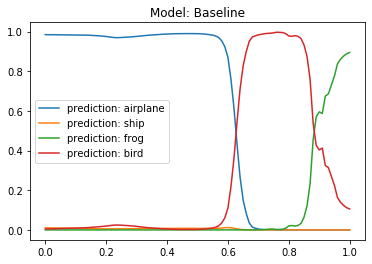

In [73]:
p.plot_predictions(cifar10_model_a)

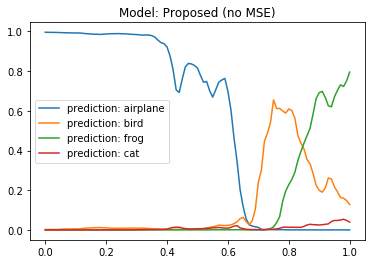

In [74]:
p.plot_predictions(cifar10_model_b)

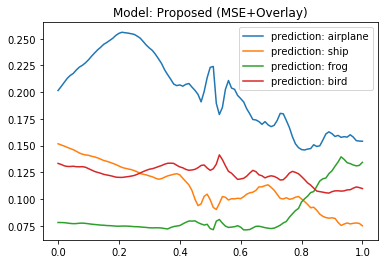

In [75]:
p.plot_predictions(cifar10_model_d)

In [76]:
p = Plotter(138, is_cifar=True)

Plotting image at index 138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


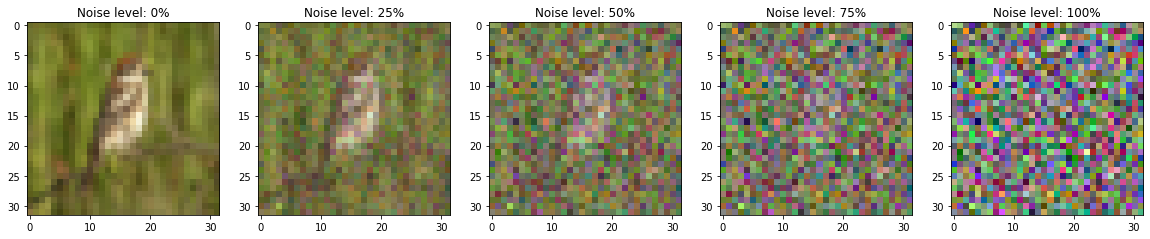

In [77]:
p.plot_transition()

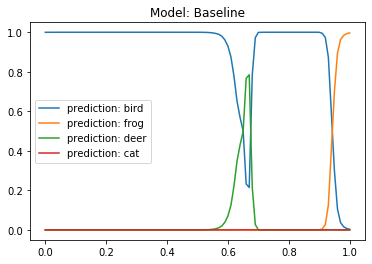

In [78]:
p.plot_predictions(cifar10_model_a)

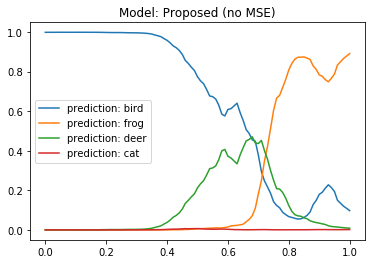

In [79]:
p.plot_predictions(cifar10_model_b)

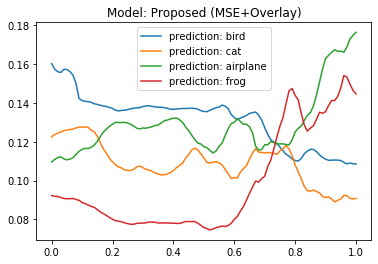

In [80]:
p.plot_predictions(cifar10_model_d)

In [81]:
p = Plotter(118, is_cifar=True)

Plotting image at index 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


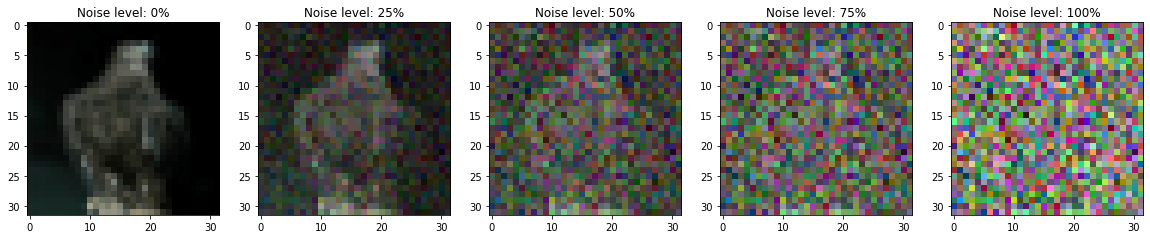

In [82]:
p.plot_transition()

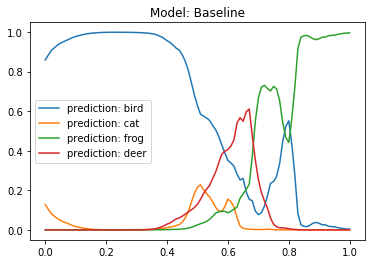

In [83]:
p.plot_predictions(cifar10_model_a)

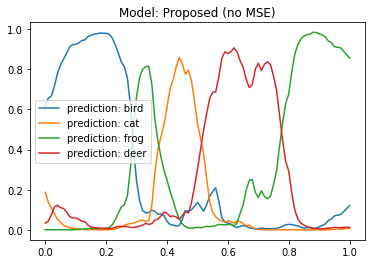

In [85]:
p.plot_predictions(cifar10_model_b)

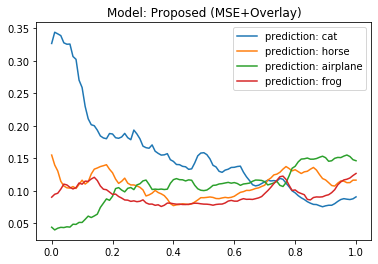

In [84]:
p.plot_predictions(cifar10_model_d)

In [66]:
p = Plotter(197, is_cifar=True)

Plotting image at index 197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


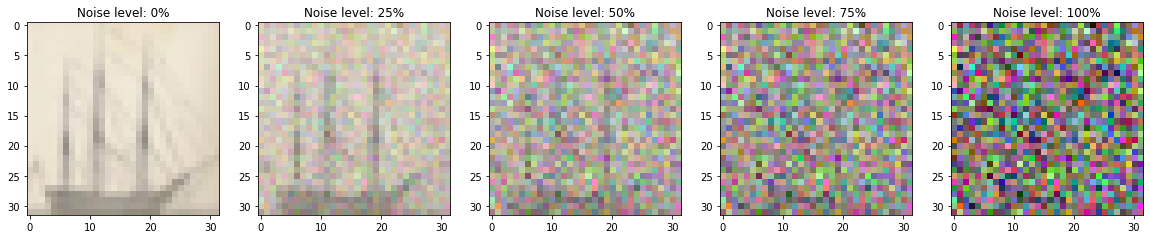

In [67]:
p.plot_transition()

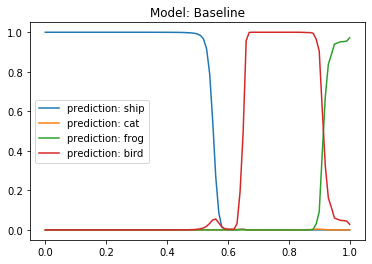

In [68]:
p.plot_predictions(cifar10_model_a)

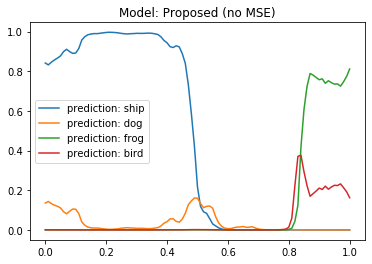

In [69]:
p.plot_predictions(cifar10_model_b)

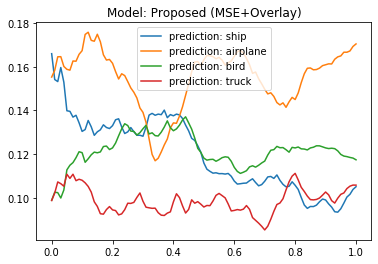

In [70]:
p.plot_predictions(cifar10_model_d)

## Measure accuracy on noise

In [36]:
noise_images = torch.randn(1000, 3, 32, 32) # used in measure_accuracy_on_noise()

In [40]:
measure_accuracy_on_noise(cifar10_model_a)

(tensor(0.), tensor(0.))

In [53]:
measure_accuracy_on_noise(cifar10_model_b)

(tensor(0.0530), tensor(0.0200))

In [41]:
measure_accuracy_on_noise(cifar10_model_c)

(tensor(0.0560), tensor(0.0284))

In [43]:
measure_accuracy_on_noise(cifar10_model_d)

(tensor(1.), tensor(0.))

## Measure max propbability

In [37]:
from scipy import stats

def compare_max_probs_on_noise(model1, model2):
    preds1, _ = model1(noise_images)
    max_probs1, _ = softmax(preds1, dim=1).max(dim=1)
    print('Model1: mean=%f, std=%f' %(max_probs1.mean().item(), max_probs1.std().item()))
    
    preds2, _ = model2(noise_images)
    max_probs2, _ = softmax(preds2, dim=1).max(dim=1)
    print('Model2: mean=%f, std=%f' %(max_probs2.mean().item(), max_probs2.std().item()))

    _, p_value = stats.ttest_ind(max_probs1.detach().numpy(), max_probs2.detach().numpy())
    print('p-value:', p_value)
    return max_probs1.mean(), max_probs2.mean()

In [38]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_b)

Model1: mean=0.933567, std=0.115321
Model2: mean=0.793023, std=0.159887
p-value: 1.8384115221932228e-100


(tensor(0.9336, grad_fn=<MeanBackward0>),
 tensor(0.7930, grad_fn=<MeanBackward0>))

In [43]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_c)

Model1: mean=0.933080, std=0.116153
Model2: mean=0.810416, std=0.161094
p-value: 6.896738755809479e-78


(tensor(0.9331, grad_fn=<MeanBackward0>),
 tensor(0.8104, grad_fn=<MeanBackward0>))

In [42]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_d)

Model1: mean=0.933567, std=0.115321
Model2: mean=0.163738, std=0.012626
p-value: 0.0


(tensor(0.9336, grad_fn=<MeanBackward0>),
 tensor(0.1637, grad_fn=<MeanBackward0>))

## Check the overlay model

The BCE+Overlay model seems to perform well on noise but actually it always give low probability everywhere and only predict accurately in 43% cases. Let's see if there's any difference between actual images and noise...?

In [87]:
preds, _ = cifar10_model_d(x)
max_probs, _ = softmax(preds, dim=1).max(dim=1)
(max_probs.mean().item(), max_probs.std().item())

(0.211810901761055, 0.10155008733272552)